# Preprocessing and Modeling

***IMPORTS***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix

import re
import string
import nltk

pd.options.display.max_colwidth = 400

***Loading in the Datasets and Adding Target Column to Distinguish Between Posts***

In [89]:
date = pd.read_csv('./data_collection_days/date_use.csv')
food = pd.read_csv('./data_collection_days/food_use.csv')

In [90]:
date['target'] = 1

In [91]:
food['target'] = 0 

***Combining the datasets***

In [92]:
combo = pd.concat([date, food], ignore_index=True)

***Using Regex to Eliminate Noise from Combined Datasets***

In [6]:
def cleaner(text):
    # Make lowercase
    text = text.lower()

    # Remove HTML special entities
    text = re.sub(r'\&\w*;', '', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    
    # Remove punctuation and split 's, 't, 've with a space for filter
    #text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    
    # Remove words with 2 or fewer letters
    #text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove whitespace (including new line characters)
    #text = re.sub(r'\s\s+', ' ', text)
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text = ''.join(c for c in text if c <= '\uFFFF') 
    
    return text

In [7]:
combo['title_and_selftext'] = combo['title_and_selftext'].apply(cleaner)

## Create X and y

In [8]:
X = combo['title_and_selftext']

y = combo['target']

***Baseline Accuracy***

In [9]:
y.value_counts(normalize = True)

1    0.625532
0    0.374468
Name: target, dtype: float64

Date makes up the majority of the accuracy score at 62.6% and Food makes up 37.4%

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [11]:
cvec = CountVectorizer()

In [12]:
cvec.fit(X_train)

CountVectorizer()

In [13]:
X_train = cvec.transform(X_train)

In [14]:
#To show as a matrix.
X_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

## Finding the Stopwords

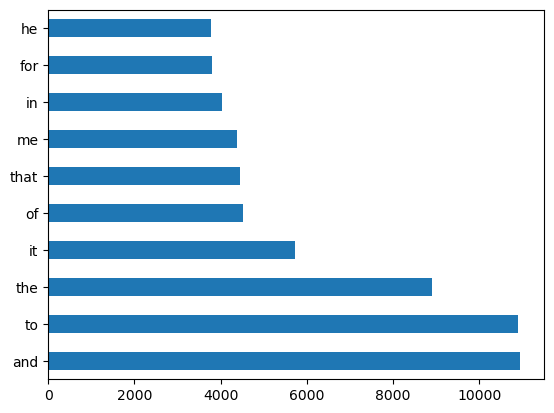

In [15]:
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names_out())

# plot top occuring words
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [16]:
# Let's look at sklearn's stopwords.
print(CountVectorizer(stop_words = 'english').get_stop_words())

frozenset({'eight', 'put', 'whither', 'beside', 'con', 'sometime', 'here', 'becoming', 'onto', 'upon', 'empty', 'ourselves', 'after', 'hereupon', 'anything', 'bottom', 'nowhere', 'five', 'also', 'still', 'all', 'thereby', 'afterwards', 'an', 'as', 'before', 'thin', 'indeed', 'describe', 'see', 'alone', 'by', 'none', 'do', 'co', 'seems', 'what', 'sometimes', 'out', 'again', 'us', 'should', 'until', 'latter', 'with', 'back', 'no', 'in', 'almost', 'about', 'hers', 'were', 'something', 'is', 'already', 'moreover', 'herself', 'nothing', 'some', 'whence', 'everything', 'less', 'into', 'another', 'perhaps', 'formerly', 'mine', 'system', 'might', 'first', 'each', 'sincere', 'nevertheless', 'otherwise', 'anywhere', 'always', 'fire', 'themselves', 'your', 'they', 'which', 'you', 'myself', 'cry', 'and', 'becomes', 'any', 'may', 'move', 'whereafter', 'done', 'not', 'between', 'few', 'everywhere', 'seeming', 'down', 'must', 'thereupon', 'whatever', 'either', 'been', 'somewhere', 'that', 'whereupon'

***Findings***
By taking out the stopwords we should be able to get to more of the meat from the posts to start looking into the modeling. The majority of the words taken out were used for imperative sentences.

## Top Words without Stopwords.

In [17]:
cvec = CountVectorizer(stop_words = 'english')

cvec.fit(combo['title_and_selftext'])

nstat = cvec.transform(combo['title_and_selftext'])

In [18]:
nstat

<2820x14992 sparse matrix of type '<class 'numpy.int64'>'
	with 149786 stored elements in Compressed Sparse Row format>

In [19]:
statdf = pd.DataFrame(nstat.todense(),
                     columns = cvec.get_feature_names_out())

In [20]:
word_counts = statdf.sum()

top_fifteen = word_counts.sort_values(ascending = False).head(15)

print(top_fifteen)

just            2985
like            2983
don             1763
ve              1661
know            1607
time            1588
want            1512
really          1416
dating          1227
feel            1161
date            1096
make             989
said             988
think            975
relationship     905
dtype: int64


***Findings***
We can see by taking out the stopwords we were left with more decisive words and key words used in the reddits chosen. This still seems like an easy model to predict though.

## Top 2 combined words in the dataset without stopwords.

In [21]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words = 'english') 

count_matrix = vectorizer.fit_transform(combo['title_and_selftext'])

vocab = vectorizer.get_feature_names_out()

bigram_counts = count_matrix.sum(axis=0)

bigram_df = pd.DataFrame({
    'Bigram': vocab,
    'Count': bigram_counts.flat
})

bigram_df_sorted = bigram_df.sort_values(by='Count', ascending=False)

print(bigram_df_sorted.head(10))


            Bigram  Count
42290    feel like    434
34969     don know    397
35125     don want    319
29350  dating apps    142
66131    just want    105
42996    felt like    102
99855  really like    101
35103    don think     95
74151    long term     89
32625    didn want     87


***Findings***
Filtered out more to see what the common phrases would be and this is looking like a better example for my problem statement.

## Lemmatizing 

In [22]:
combolem = combo

In [23]:
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    pos_tag = nltk.pos_tag([word])[0][1]
    pos = get_wordnet_pos(pos_tag)
    if pos:
        return lemmatizer.lemmatize(word, pos=pos)
    else:
        return lemmatizer.lemmatize(word)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

combolem['lemmatized_text'] = combolem['title_and_selftext'].apply(lambda x: ' '.join([lemmatize_word(word) for word in x.split()]))

#print(combolem)

***Lemmatized*** The text and set it to a new column to run models down the line if I needed to grab words that had any overlap. For example, dating is a word I am seeing variations of in the top words.

## Stemming

In [24]:
combostem = combo

In [25]:
def porter_stemmer_tokenize(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text.split()]

# Apply stemming to the 'text' column
combostem['stemmed_text'] = combostem['title_and_selftext'].apply(lambda x: ' '.join(porter_stemmer_tokenize(x)))

***Stemming*** Same thing I did with the lemmatized section but probably won't use since it cut down my words too crudely to use. 

## Running a Logistic Regression to Test Model Performance with No Stop Words.

In [26]:
X = combo['title_and_selftext']

y = combo['target']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [28]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english')),
    ('lr', LogisticRegression())
])

In [29]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 4],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'lr__penalty': ['l2', 'none']
}

In [30]:
gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs = -1)

gs.fit(X_train, y_train)
print(gs.best_score_) # through cross-val
gs.best_params_

0.9919621749408984


{'cvec__max_df': 1.0,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'lr__penalty': 'l2'}

In [31]:
len(gs.best_estimator_.named_steps['lr'].coef_[0])

4000

***Evaluation*** The model just without stop words is operating too well with a best score of 99.2%. This means that there needs to be some extra cleaning since I am looking for a lower performing model, since my goal is to show overlap in whether someone is asking for culinary advice or dating advice.

## Taking out some top words to see the difference in the model efficiency for problem statement and using bigrams.

In [32]:
print(top_fifteen)

just            2985
like            2983
don             1763
ve              1661
know            1607
time            1588
want            1512
really          1416
dating          1227
feel            1161
date            1096
make             989
said             988
think            975
relationship     905
dtype: int64


In [33]:
print(CountVectorizer(stop_words = 'english').get_stop_words())

frozenset({'eight', 'put', 'whither', 'beside', 'con', 'sometime', 'here', 'becoming', 'onto', 'upon', 'empty', 'ourselves', 'after', 'hereupon', 'anything', 'bottom', 'nowhere', 'five', 'also', 'still', 'all', 'thereby', 'afterwards', 'an', 'as', 'before', 'thin', 'indeed', 'describe', 'see', 'alone', 'by', 'none', 'do', 'co', 'seems', 'what', 'sometimes', 'out', 'again', 'us', 'should', 'until', 'latter', 'with', 'back', 'no', 'in', 'almost', 'about', 'hers', 'were', 'something', 'is', 'already', 'moreover', 'herself', 'nothing', 'some', 'whence', 'everything', 'less', 'into', 'another', 'perhaps', 'formerly', 'mine', 'system', 'might', 'first', 'each', 'sincere', 'nevertheless', 'otherwise', 'anywhere', 'always', 'fire', 'themselves', 'your', 'they', 'which', 'you', 'myself', 'cry', 'and', 'becomes', 'any', 'may', 'move', 'whereafter', 'done', 'not', 'between', 'few', 'everywhere', 'seeming', 'down', 'must', 'thereupon', 'whatever', 'either', 'been', 'somewhere', 'that', 'whereupon'

In [34]:
project = ['however', 'please', 'beside', 'there', 'wherein', 'your', 'whence', 'eleven', 'done', 'anyone', 'nowhere', 'around', 'none', 'thin', 'before', 'any', 'must', 'their', 'those', 'toward', 'third', 'keep', 'via', 'latterly', 'them', 'every', 'hundred', 'that', 'others', 'inc', 'hereupon', 'former', 'couldnt', 'front', 'several', 'without', 'me', 'show', 'take', 'again', 'not', 'its', 'is', 'six', 'mine', 'detail', 'describe', 'all', 'alone', 'if', 'neither', 'are', 'few', 'over', 'therefore', 'next', 'still', 'behind', 'rather', 'became', 'moreover', 'no', 'find', 'along', 'thru', 'becomes', 'anything', 'beforehand', 'within', 'out', 'of', 'where', 'than', 'together', 'thick', 'forty', 'whether', 'ie', 'name', 'can', 'mill', 'side', 'three', 're', 'the', 'five', 'mostly', 'thus', 'call', 'upon', 'de', 'and', 'this', 'in', 'under', 'by', 'noone', 'itself', 'she', 'nor', 'whither', 'top', 'thence', 'becoming', 'off', 'four', 'due', 'cant', 'hers', 'then', 'nine', 'will', 'whereas', 'nevertheless', 'eg', 'otherwise', 'through', 'thereby', 'since', 'sixty', 'seeming', 'either', 'always', 'throughout', 'his', 'get', 'down', 'sincere', 'been', 'i', 'un', 'myself', 'back', 'why', 'between', 'almost', 'bottom', 'see', 'which', 'anyhow', 'even', 'etc', 'himself', 'wherever', 'fire', 'twenty', 'ourselves', 'ltd', 'namely', 'seemed', 'although', 'co', 'on', 'bill', 'sometimes', 'eight', 'whose', 'yours', 'among', 'except', 'may', 'or', 'seem', 'onto', 'amongst', 'sometime', 'per', 'might', 'nobody', 'towards', 'an', 'yet', 'has', 'last', 'become', 'perhaps', 'such', 'how', 'these', 'whom', 'well', 'somehow', 'we', 'hereafter', 'whole', 'from', 'else', 'were', 'into', 'more', 'only', 'thereupon', 'empty', 'each', 'you', 'much', 'her', 'give', 'least', 'latter', 'him', 'con', 'for', 'yourselves', 'with', 'both', 'part', 'very', 'never', 'interest', 'above', 'here', 'below', 'go', 'amount', 'they', 'he', 'should', 'everywhere', 'also', 'fifteen', 'be', 'up', 'too', 'besides', 'elsewhere', 'already', 'first', 'somewhere', 'whereafter', 'whatever', 'beyond', 'less', 'hence', 'whereby', 'had', 'cry', 'many', 'a', 'ever', 'could', 'ours', 'whenever', 'at', 'during', 'so', 'everyone', 'hasnt', 'further', 'system', 'what', 'across', 'being', 'someone', 'until', 'now', 'am', 'put', 'was', 'fill', 'indeed', 'would', 'but', 'do', 'one', 'same', 'anywhere', 'it', 'serious', 'something', 'while', 'therein', 'meanwhile', 'afterwards', 'everything', 'my', 'often', 'found', 'other', 'nothing', 'two', 'about', 'ten', 'who', 'fifty', 'themselves', 'thereafter', 'after', 'own', 'once', 'enough', 'seems', 'cannot', 'hereby', 'herself', 'our', 'when', 'to', 'formerly', 'herein', 'some', 'though', 'move', 'another', 'because', 'us', 'whoever', 'as', 'twelve', 'most', 'yourself', 'against', 'have', 'amoungst', 'full', 'made', 'whereupon', 'anyway','ve', 'dating', 'date', 'relationship', 'don', 'guy', 'girl','recipe','chicken', 'water', 'sauce', 'cook', 'social', 'media', 'year', 'years', 'months', 'distance', 'sex', 'friend', 'month', 'talk', 'say', 'flag']

In [35]:
#Added words like don, ve, dating, date, relationship, guy, girl, recipe, chicken, water, sauce, cook, social, media, year, years, months, distance, sex, friend, month, talk, say, flag.  
print(CountVectorizer(stop_words = project))

CountVectorizer(stop_words=['however', 'please', 'beside', 'there', 'wherein',
                            'your', 'whence', 'eleven', 'done', 'anyone',
                            'nowhere', 'around', 'none', 'thin', 'before',
                            'any', 'must', 'their', 'those', 'toward', 'third',
                            'keep', 'via', 'latterly', 'them', 'every',
                            'hundred', 'that', 'others', 'inc', ...])


## Second Logistic Regression but Using the Lemmatized Text and Bigrams.

In [36]:
X = combo['lemmatized_text']
y = combo['target']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [38]:
cvec = CountVectorizer(ngram_range=(2, 2), stop_words = project)

cvec.fit(X_train)

ntrain = cvec.transform(X_train)

In [39]:
ntest = cvec.transform(X_test)

In [40]:
statdf = pd.DataFrame(ntrain.todense(),
                     columns = cvec.get_feature_names_out())

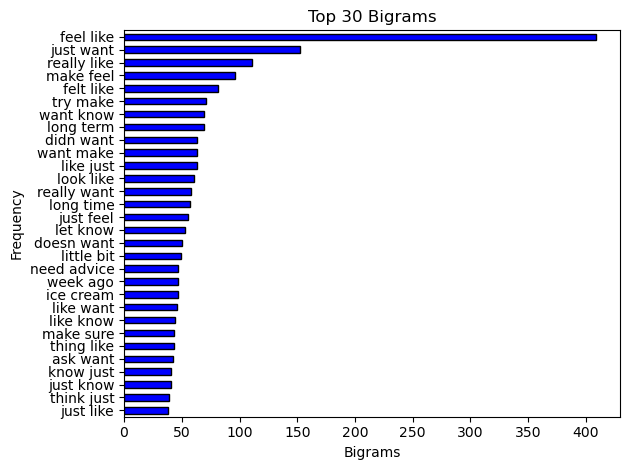

<Figure size 640x480 with 0 Axes>

In [94]:
word_counts = statdf.sum()

top_fifteen = word_counts.sort_values(ascending = False).head(30)

top_fifteen = top_fifteen[::-1]
top_fifteen.plot(kind = 'barh', color = 'blue', edgecolor = 'black')
plt.title('Top 30 Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.savefig('./images/bigrams.png', bbox_inches = 'tight')

In [42]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(stop_words='english')),
                ('lr', LogisticRegression())])

In [43]:
pipe = Pipeline([
    ('cvec', CountVectorizer(ngram_range=(2, 2), stop_words = project)),
    ('lr', LogisticRegression())
])

In [44]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 4],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'lr__penalty': ['l2', None]
}

In [45]:
gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs = -1)

gs.fit(X_train, y_train)
print(gs.best_score_) # through cross-val
gs.best_params_

0.88274231678487


{'cvec__max_df': 1.0,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'lr__penalty': 'l2'}

In [46]:
print(gs.score(X_train, y_train))

print(gs.score(X_test, y_test))

0.9777777777777777
0.8950354609929078


***Score Evaluations***
+ The model is performing better towards my problem statement. 
+ Cross val best score = 88.3%
+ Train GridSearch Score = 97.8%
+ Test GridSearch Score = 89.5%
+ Overfit model but it is working quite well.

## Model Evaluation

In [47]:
pred = gs.predict(X_test)

In [48]:
# Accuracy Rate
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9777777777777777
0.8950354609929078


In [49]:
# Misclassification Rate
print(1 - gs.score(X_train, y_train))
print(1 - gs.score(X_test, y_test))

0.022222222222222254
0.10496453900709224


In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

In [51]:
#Specificity
spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 0.9128787878787878


In [52]:
#Recall
recall = tp / (tp + fn)

if recall == 1.0:
    print("We have Total Recall")
else:
    print(f'Recall: {recall}')

Recall: 0.8843537414965986


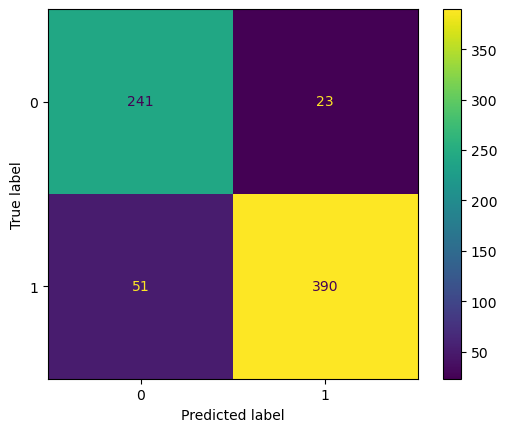

In [53]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

***Findings***
+ Train = 97.8%
+ Test = 89.5%
+ Missclassification Rate = Train - 2.2% Test - 10.5%
+ Specificity = 91.3%
+ Recall = 88.4%

## Model 2 KNN to See How Other Models Will Perform

In [54]:
pipe_knn = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(2, 2), stop_words = project)),
    ('knn', KNeighborsClassifier())
])

pipe_knn_params = {
    'tf__stop_words': [None, 'english'],
    'tf__max_features': [2000, 3000, 4000],
    'tf__min_df': [2, 3, 4],
    'tf__max_df': [1.0, 0.95, 0.9],
    'knn__n_neighbors': range(3, 10, 2)
}

gs_knn = GridSearchCV(pipe_knn,
                     param_grid=pipe_knn_params,
                     n_jobs = -1)

gs_knn.fit(X_train, y_train)
print(gs_knn.best_score_)
print(gs_knn.best_params_)

0.7966903073286052
{'knn__n_neighbors': 9, 'tf__max_df': 1.0, 'tf__max_features': 4000, 'tf__min_df': 3, 'tf__stop_words': None}


In [55]:
print(gs_knn.score(X_train, y_train))
print(gs_knn.score(X_test, y_test))

0.9981087470449173
0.6368794326241135


***Findings***

+ KNN Best score = 79.7%
+ Train = 99.8%
+ Test = 63.7%
+ Probably won't want to use this since the KNN testing model did not perform well on the testing data so it would make it very hard to predict my model with the also stance of overfitting. 

# Model 3 - CART = Classification and Regression Trees

In [56]:
# Define Gini function, called gini.
def gini(obs):
    # create a list of to score my square probabilities
    gini_sum = []
    
    for class_i in set(obs):
        # calc observed probability of class_i
        prob  = (obs.count(class_i) / len(obs))
        
        # square the probability and append it to gini_sum
        gini_sum.append(prob**2)
        
    # return our gini impurity
    return 1 - sum(gini_sum)

In [57]:
y = list(combo['target'])

gini(y)

0.46848347668628343

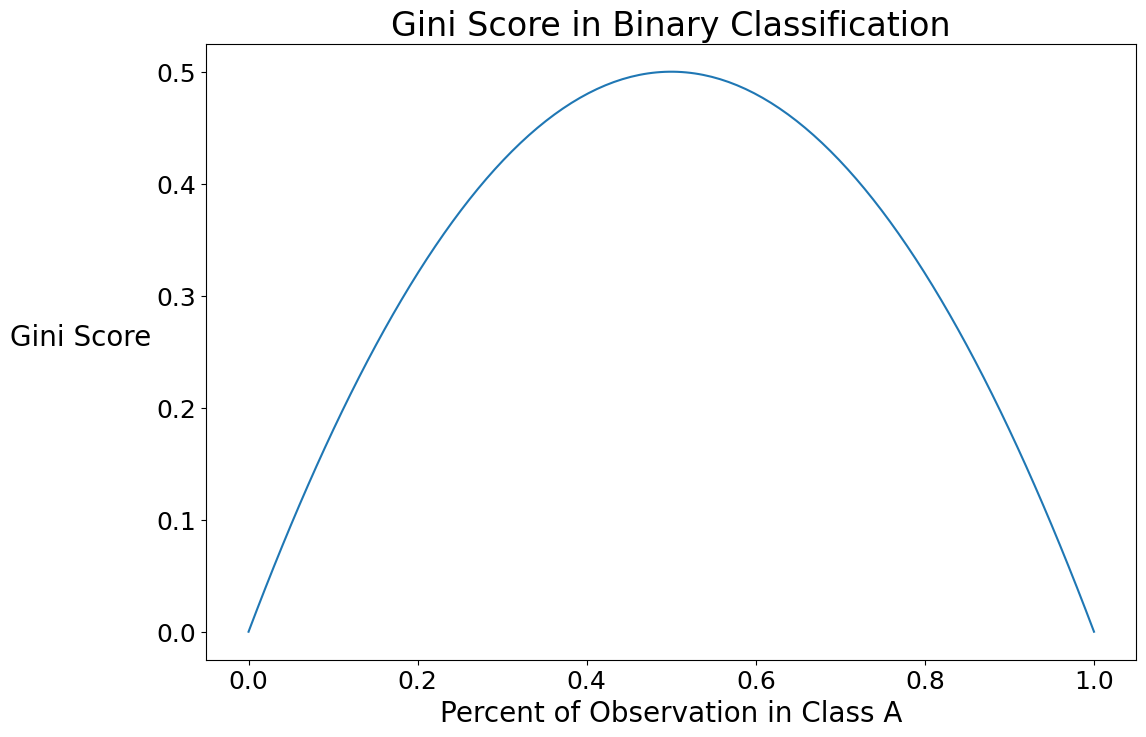

In [58]:
# Set figure size.
plt.figure(figsize = (12,8))

# # Generate x values (for percentage of obs. in class A).
percent_in_class_A = np.linspace(0, 1, 200)
percent_in_class_B = 1 - percent_in_class_A

# # Calculate Gini values.
gini_values = 1 - np.square(percent_in_class_A) - np.square(percent_in_class_B)

# # Plot line.
plt.plot(percent_in_class_A,
          gini_values)

# # Establish title, axes, and labels.
plt.title('Gini Score in Binary Classification', fontsize = 24)
plt.xlabel('Percent of Observation in Class A', fontsize = 20)
plt.ylabel('Gini Score', fontsize = 20, rotation = 0, ha = 'right')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18);

***Interpretation***

We have a 46.7% chance to missclassify our model. This mean we have a 53.3% chance to predict correctly and will also serve as out baseline. 

***Decision Tree Classifier***

In [59]:
dt = DecisionTreeClassifier(random_state = 42)

In [60]:
dt.fit(ntrain, y_train)

DecisionTreeClassifier(random_state=42)

In [61]:
print(f'Score on training set: {dt.score(ntrain, y_train)}')
print(f'Score on testing set: {dt.score(ntest, y_test)}')

Score on training set: 1.0
Score on testing set: 0.7446808510638298


***Trying the decision tree with hyperparameters***

In [62]:
# Instantiate model with:
# - a maximum depth of 5.
# - at least 7 samples required in order to split an internal node.
# - at least 3 samples in each leaf node.
# - a cost complexity of 0.01.
# - random state of 42.

dt = DecisionTreeClassifier(max_depth = 5,
                           min_samples_split=5,
                           min_samples_leaf=2,
                           ccp_alpha=0.01,
                           random_state = 42)

In [63]:
dt.fit(ntrain, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)

In [64]:
# Evaluate model.
print(f'Score on training set: {dt.score(ntrain, y_train)}')
print(f'Score on testing set: {dt.score(ntest, y_test)}')

Score on training set: 0.625531914893617
Score on testing set: 0.625531914893617


***Findings***

+ Without Hyper Parameters - Train = 100%, Test = 74.5%
+ With Hyper Parameters - Train = 62.5%, Test = 62.5%
+ Just by going of the lemmatized text alone and adjusting hyperparameters we drop to the baseline accuracy of the model. 
+ When I tried running a gridsearch the model would never stop running so due to the previous data I will not use this model over the others.

## Model 4: Ensemble Learning: Bagging (using Bootstrapping as a classifier)

In [65]:
# Instantiate BaggingClassifier.
bag = BaggingClassifier(random_state = 42)

# Fit BaggingClassifier.
bag.fit(ntrain, y_train)

# Score BaggingClassifier.
print(bag.score(ntrain, y_train))
print(bag.score(ntest, y_test))

0.9943262411347518
0.8099290780141843


Train = 99.4%
Test = 81%

In [66]:
#now adding more estimators --> 50 trees

# Instantiate BaggingClassifier.
bag = BaggingClassifier(n_estimators=50,random_state=42)

# Fit BaggingClassifier.
bag.fit(ntrain, y_train)

# Score BaggingClassifier.
print(bag.score(ntrain, y_train))
print(bag.score(ntest, y_test))

1.0
0.8638297872340426


Train = 100%
Test = 86.4%

***Findings***
+ Before adding more trees - Train = 99%, Test = 81%
+ After adding 50 trees - Train = 100%, Test = 86.4%
+ By adding more trees we did improve the testing rate of the model however it is still overfit with training now being 100%.

## Model 5: Ensemble Learning: Boosting

In [72]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier())

ada_params = {
    'n_estimators': [50, 100],
    'estimator__max_depth': [1, 2],
    'learning_rate': [0.9, 1.1]
}

gs = GridSearchCV(ada, param_grid=ada_params, cv = 3, n_jobs = -1)

gs.fit(ntrain, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'estimator__max_depth': [1, 2],
                         'learning_rate': [0.9, 1.1],
                         'n_estimators': [50, 100]})

In [73]:
gs.best_score_

0.7527186761229315

In [74]:
gs.best_params_

{'estimator__max_depth': 2, 'learning_rate': 0.9, 'n_estimators': 100}

In [75]:
gs.score(ntrain, y_train), gs.score(ntest, y_test)

(0.8794326241134752, 0.7432624113475177)

***Findings***
+ AdaBoost best score = 75.3%
+ Train = 87.9%
+ Test = 74.3%
+ Still an overfit model with my testing accuracy lower than the other models as well.

# Conclusion

Out of all the models used for the problem statement the best results were provided by my Logistic Regression model boasting a 89.5% testing score. Giving me a pretty firm model in terms of seeing if you were asking for culinary advice or dating advice. In terms of just searching by solo words, the model works even better, but my main aim was to look at the phrases shared in each. By applying bigrams, the models had a harder time predicting what reddit the post was coming from. Coupled with the removal of key words from both subreddits we came to an even more balanced model, giving better insight on what may be leading into the differences between the two. This left me to use the other models to inference details about the way my problem statement was behaving. 

The KNN model showed that we did not follow a Bernoulli distribution and that our observations were not indepent of the other. This gave us a poor test score at 63.7% with a large overfitting on the training data. Sadly, the next model focusing on decision trees did not fair much better. With a gini score of 46.8%, we could see that almost half the time our decision tree would be missclassifying the next prediction. This led to an overfit model until we added the hyperparameters to control the overfitting. Once the hyperparameters were in place we no longer had an overfit model with both train and test scores placing at 62.5%, which ended up being right at our baseline point. This meant that tuning depth, splits, and sample data would effect the results of the model dramatically. Leaving us with the final two models I ran being bagging and AdaBoosting. 

Both of the bagging and boosting methods worked better for the project at hand. Bagging providing the better results after a gridsearch adding 50 trees at, 86.4%. This would make sense since our decision tree seemed to grow accustomed to some irregualr patterns from the overfitting of the training set. By adding more exposure to the trees by introducing sub-samples of the training set, we ended up with a better accuracy for our testing model. This gave us a good contrast in terms of then viewing boostings scores. The boosted test scores after running a gridsearch were, 74.3% causing quite a gap to be viewed between the two. This meant that the repeated weighing of weak learners to increase influence over the model was not effective. Giving us a good idea that our model learns better through recognizing pattern recognition instead of emphasizing value on seperate sections. 

I would recommend that the acquisition of more data and the time to run more modeling would help the project immensely. For future testing and exploration of the subject, having a more balanced data set would be ideal to avoid overfitting. I would also recommend that since there are quite a few relationships in the phrases used in both subreddits that we should add a few more stop words to the final operating models. 